In [1]:
if True:
    from google.colab import drive
    drive.mount("/content/d")
if True:
    from IPython.display import clear_output
    !pip install -q kaggle
    clear_output()
    !mkdir ~/.kaggle
    !cp d/MyDrive/kaggle/kaggle.json ~/.kaggle
    !kaggle competitions download -c digit-recognizer
    !unzip digit-recognizer.zip

 46% 7.00M/15.3M [00:00<00:00, 73.4MB/s]
100% 15.3M/15.3M [00:00<00:00, 111MB/s] 
Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split

trainPath = "train.csv"
testPath = "test.csv"

BATCH_SIZE = 64
RANDOM_STATE = 13

# MODEL FIT

In [3]:
# get the train sample
train = np.genfromtxt(trainPath, delimiter=",", skip_header=1)

# shuffle for the better fit
random.Random(RANDOM_STATE).shuffle(train)

# get a subsample for the validation check
train, valid = train_test_split(train, test_size=0.2, random_state=RANDOM_STATE)
print(f"split shapes: {train.shape, valid.shape}")

# get the labels and pixels ad the features
y_tr, y_vl = train[:, 0], valid[:, 0]
x_tr, x_vl = train[:,1:].reshape(-1, 28, 28), valid[:,1:].reshape(-1, 28, 28)
print(x_tr.shape, y_tr.shape, x_vl.shape, y_vl.shape)

split shapes: ((33600, 785), (8400, 785))
(33600, 28, 28) (33600,) (8400, 28, 28) (8400,)


In [4]:
''' prepare the train and test samples'''

def norm(x_tr, y_tr): # normalizer (max pixel value = 255)
    return x_tr / 255., y_tr

def get_ds(x_tr, y_tr):
    ''' set the data process pipe '''
    # convert x and y numpy arrays to tf dataset
    ds_tr = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
    # normalize the pixels data
    ds_tr = ds_tr.map(norm)
    # cache dataset for a better performance
    ds_tr = ds_tr.cache()
    # shuffle for the better fit
    ds_tr = ds_tr.shuffle(int(len(y_tr)/30))
    # set fit by batches
    ds_tr = ds_tr.batch(BATCH_SIZE)
    # tf tool to reduce processing time
    ds_tr = ds_tr.prefetch(tf.data.AUTOTUNE)

    return ds_tr

ds_tr = get_ds(x_tr, y_tr) # dataset to fit the model
ds_vl = get_ds(x_vl, y_vl) # dataset for validate the model

In [87]:
''' model initialization and launch: dense layers within '''

model_sequential = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model_sequential.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
model_sequential.fit(
    ds_tr,
    epochs=5,
    validation_data=ds_vl,
)

Epoch 1/5
525/525 [==============================] - 2s 4ms/step - loss: 0.3575 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.2103 - val_sparse_categorical_accuracy: 0.9423
Epoch 2/5
525/525 [==============================] - 2s 3ms/step - loss: 0.1516 - sparse_categorical_accuracy: 0.9581 - val_loss: 0.1276 - val_sparse_categorical_accuracy: 0.9648
Epoch 3/5
525/525 [==============================] - 2s 3ms/step - loss: 0.0986 - sparse_categorical_accuracy: 0.9739 - val_loss: 0.0972 - val_sparse_categorical_accuracy: 0.9724
Epoch 4/5
525/525 [==============================] - 2s 3ms/step - loss: 0.0685 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.0791 - val_sparse_categorical_accuracy: 0.9775
Epoch 5/5
525/525 [==============================] - 2s 3ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.0662 - val_sparse_categorical_accuracy: 0.9806


In [6]:
print(
    f"las metricas del modelo de la ulitma epoca"\
    f"\naccuracy: {model_sequential.evaluate(ds_vl, verbose=0)[1]:.4f}"\
    f"\nloss: {model_sequential.evaluate(ds_vl, verbose=0)[0]:.4f}"
)

las metricas del modelo de la ulitma epoca
accuracy: 0.9894
loss: 0.0436


In [69]:
''' model initialization and launch: convolutional layers '''

model_convolutional = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(4, 4),
        padding="same",
        activation="relu",
        input_shape=(28,28,1)
    ),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(4, 4),
        padding="same",
        activation="relu",
    ),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(128, activation='relu'),

])
model_convolutional.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
model_convolutional.fit(
    ds_tr,
    epochs=8,
    validation_data=ds_vl,
)

Epoch 1/8
525/525 [==============================] - 4s 6ms/step - loss: 0.7355 - sparse_categorical_accuracy: 0.7748 - val_loss: 0.1599 - val_sparse_categorical_accuracy: 0.9575
Epoch 2/8
525/525 [==============================] - 3s 6ms/step - loss: 0.2095 - sparse_categorical_accuracy: 0.9350 - val_loss: 0.0926 - val_sparse_categorical_accuracy: 0.9761
Epoch 3/8
525/525 [==============================] - 2s 5ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.9530 - val_loss: 0.0754 - val_sparse_categorical_accuracy: 0.9812
Epoch 4/8
525/525 [==============================] - 2s 5ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.0641 - val_sparse_categorical_accuracy: 0.9823
Epoch 5/8
525/525 [==============================] - 3s 7ms/step - loss: 0.1108 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.0537 - val_sparse_categorical_accuracy: 0.9856
Epoch 6/8
525/525 [==============================] - 2s 5ms/step - loss: 0.0983 - sparse_categorical_accu

In [8]:
print(
    f"las metricas del modelo de la ulitma epoca"\
    f"\naccuracy: {model_convolutional.evaluate(ds_vl, verbose=0)[1]:.4f}"\
    f"\nloss: {model_convolutional.evaluate(ds_vl, verbose=0)[0]:.4f}"
)

las metricas del modelo de la ulitma epoca
accuracy: 0.9890
loss: 0.0374


# PREDICT

In [9]:
''' predict image from the test sample '''

# upload test sample
test = np.genfromtxt(testPath, delimiter=",", skip_header=1)
test = test.reshape(-1, 28, 28)

prediction : 7


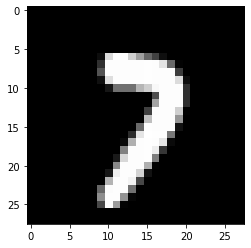

In [82]:
n = 29
plt.imshow(test[n], cmap=plt.cm.gray);
print(f"prediction : {np.argmax(model_sequential.predict(test[n].reshape(1, 28, 28), verbose=0))}")

prediction : 0


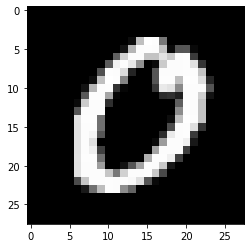

In [74]:
n = 189
plt.imshow(test[n], cmap=plt.cm.gray);
print(f"prediction : {np.argmax(model_sequential.predict(test[n].reshape(1, 28, 28), verbose=0))}")

--2022-11-29 19:18:01--  https://i.stack.imgur.com/qg0H2.png
Resolving i.stack.imgur.com (i.stack.imgur.com)... 146.75.32.193
Connecting to i.stack.imgur.com (i.stack.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1162 (1.1K) [image/png]
Saving to: ‘test.png’

test.png            100%[===================>]   1.13K  --.-KB/s    in 0s      

2022-11-29 19:18:01 (74.8 MB/s) - ‘test.png’ saved [1162/1162]

(280, 280)
prediction : 8


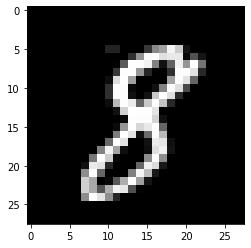

In [91]:
''' predict a digit in any image '''

# upload some digit
!wget -O "test.png" "https://i.stack.imgur.com/qg0H2.png"
# convert image to the array
img = np.array(Image.open('test.png').convert('L'))
print(img.shape)
# resize the image for the model input
img = cv2.resize(img, (28, 28))
# predict
plt.imshow(img, cmap=plt.cm.gray);
print(f"prediction : {np.argmax(model_sequential.predict(img.reshape(1, 28, 28), verbose=0))}")